# News Analysis with LLM (Gemini)

In [8]:
import os
from dotenv import load_dotenv

load_dotenv("secret.env")

api_key = os.getenv("GEMINI_API_KEY")

if api_key is None:
    print("Error: GEMINI_API_KEY not found in .env file or environment variables.")
else:
    print("GEMINI_API_KEY loaded successfully.")

GEMINI_API_KEY loaded successfully.


In [9]:
import google.generativeai as genai
from tqdm import tqdm

genai.configure(api_key=api_key)
generation_config = genai.GenerationConfig(
        temperature=0,
)
model = genai.GenerativeModel("gemini-2.5-flash-preview-04-17", generation_config=generation_config)

In [10]:
from google.api_core import retry

# Catch transient Gemini errors.
def is_retryable(e) -> bool:
    if retry.if_transient_error(e):
        # Good practice, but probably won't fire with the google-genai SDK
        return True
    elif (isinstance(e, genai.errors.ClientError) and e.code == 429):
        # Catch 429 quota exceeded errors
        return True
    elif (isinstance(e, genai.errors.ServerError) and e.code == 503):
        # Catch 503 model overloaded errors
        return True
    else:
        return False

@retry.Retry(predicate=is_retryable)
def generate_content_with_rate_limit(prompt):
  return model.generate_content(prompt).text

In [11]:
prompt = """You are a financial news analyst specializing in stock market impact. Your task is to analyze the provided news article, summarize its core content concisely, determine its sentiment (positive, negative, or neutral), and assess its importance to the specified stock.

Here is the news from stock [STOCK] title and body:
---
[TITLE]
---
[BODY]
---

Please provide your analysis in the following format (Don't forget to make space between the sections as shown):

**Sentiment:**
[Positive / Negative / Neutral]

**Summary:**
[Your concise summary of the article, typically 2-3 sentences.]

**Reasoning for Sentiment:**
[Brief explanation (1-2 sentences) of why you categorized the sentiment as such, referencing key points or tone from the article.]

**Importance to Stock [STOCK]:**
[1-5, where 1 is minimal importance and 5 is very high importance.Answer in 1-5 only, no explanation.] (Answer only in number 1-5)

**Reasoning for Importance:**
[Brief explanation (1-2 sentences) of why you assigned this importance score, referencing specific details from the article that would impact the stock.]"""

In [12]:
import pandas as pd
import numpy as np

In [13]:
df = pd.read_csv("../../DataCollection/Data/Trending_News/2025-05-28_14-25-05.csv")
display(df.head())

,publish_date,publish_time,title,body_text,url
0,2025-05-28,03:10,sell Nvidia ahead of earnings? Here’s what our...,Investing.com -- The moment the market has bee...,https://www.investing.com/news/stock-market-ne...
1,2025-05-28,01:51,Bitcoin price today: steady at $109k amid legi...,"Investing.com-- held steady on Wednesday, rema...",https://www.investing.com/news/cryptocurrency-...
2,2025-05-28,00:18,Nvidia Asian suppliers advance ahead of Q1 ear...,Investing.com-- Shares of Nvidia’s Asian suppl...,https://www.investing.com/news/stock-market-ne...
3,2025-05-27,22:52,Asia stocks rise tracking Wall St gains; Tech ...,Investing.com-- Most Asian stocks rose on Wedn...,https://www.investing.com/news/stock-market-ne...
4,2025-05-27,20:39,"Trump says Golden Dome to cost Canada $61 bln,...",Investing.com-- U.S. President Donald Trump sa...,https://www.investing.com/news/economy-news/tr...


In [14]:
df.isnull().sum()

publish_date    0
publish_time    0
title           0
body_text       0
url             0
dtype: int64

In [15]:
df["title"] = df["title"].astype(str)
df["body_text"] = df["body_text"].astype(str)

In [16]:
print(df.head())

  publish_date publish_time  \
0   2025-05-28        03:10   
1   2025-05-28        01:51   
2   2025-05-28        00:18   
3   2025-05-27        22:52   
4   2025-05-27        20:39   

                                               title  \
0  sell Nvidia ahead of earnings? Here’s what our...   
1  Bitcoin price today: steady at $109k amid legi...   
2  Nvidia Asian suppliers advance ahead of Q1 ear...   
3  Asia stocks rise tracking Wall St gains; Tech ...   
4  Trump says Golden Dome to cost Canada $61 bln,...   

                                           body_text  \
0  Investing.com -- The moment the market has bee...   
1  Investing.com-- held steady on Wednesday, rema...   
2  Investing.com-- Shares of Nvidia’s Asian suppl...   
3  Investing.com-- Most Asian stocks rose on Wedn...   
4  Investing.com-- U.S. President Donald Trump sa...   

                                                 url  
0  https://www.investing.com/news/stock-market-ne...  
1  https://www.investing.com/

In [17]:
predicted = []

for index, row in tqdm(df.iterrows(), total=len(df), desc="Prompting"): 
    current_stock = row.get("ticker", "news")

    filled_prompt = prompt.replace("[STOCK]", current_stock)
    filled_prompt = filled_prompt.replace("[TITLE]", row["title"])
    filled_prompt = filled_prompt.replace("[BODY]", row["body_text"])

    try:
        response = generate_content_with_rate_limit(filled_prompt)
        finalprediction = response.strip()
        if not finalprediction:
            print(f"Row {index}: LLM returned an empty string.")
            predicted.append("LLM_EMPTY_RESPONSE")
        else:
            predicted.append(finalprediction)
    except ValueError as ve:
        print(f"Row {index}: ValueError - {ve}. Appending 'ERROR_VALUE_ERROR'.")
        predicted.append("ERROR_VALUE_ERROR")
        continue
    except Exception as e:
        if "429 Too Many Requests" in str(e) or "quota" in str(e).lower():
            print(f"Row {index}: Rate Limit Exceeded or Quota Error - {e}. Appending 'ERROR_RATE_LIMIT'.")
            predicted.append("ERROR_RATE_LIMIT")
        elif "safety" in str(e).lower() or "blocked" in str(e).lower():
             print(f"Row {index}: Content Safety/Blocked - {e}. Appending 'ERROR_SAFETY_BLOCKED'.")
             predicted.append("ERROR_SAFETY_BLOCKED")
        else:
            print(f"Row {index}: Unexpected Error - {e}. Appending 'ERROR_UNEXPECTED'.")
            predicted.append("ERROR_UNEXPECTED")
        continue

Prompting:   0%|          | 0/20 [00:00<?, ?it/s]

Prompting: 100%|██████████| 20/20 [01:54<00:00,  5.72s/it]


In [18]:
predicted = np.array(predicted)
df["predicted"] = predicted

In [19]:
print(df["title"][2],'\n\n',predicted[2])

Nvidia Asian suppliers advance ahead of Q1 earnings By Investing.com 

 **Sentiment:**
Neutral

**Summary:**
Shares of Nvidia's Asian suppliers advanced ahead of the company's first-quarter earnings report, driven by investor anticipation of strong results. While suppliers like Samsung, SK Hynix, and TSMC saw gains, the article notes past instances of Nvidia's stock underperforming post-earnings and highlights potential future challenges like China controls and shifts in AI demand.

**Reasoning for Sentiment:**
The article reports on positive stock movements for suppliers but balances this with discussion of potential risks and past negative trends surrounding Nvidia's earnings reports, presenting a mixed picture rather than a purely positive or negative one.

**Importance to Stock news:**
5

**Reasoning for Importance:**
The news directly discusses market positioning ahead of Nvidia's Q1 earnings, expected results, past stock reactions to earnings, and potential future demand drivers/

In [20]:
df["sentiment"] = df["predicted"].apply(lambda x: x.split("\n")[1].strip() if len(x.split("\n")) > 1 else None)
df["importance"] = df["predicted"].apply(lambda x: x.split("\n")[10].strip() if len(x.split("\n")) > 10 else None)
df["summary"] = df["predicted"].apply(lambda x: x.split("\n")[4].strip() if len(x.split("\n")) > 4 else None)

In [21]:
df[df["importance"]== "5"][["publish_date","title", "sentiment","importance", "summary"]]

,publish_date,title,sentiment,importance,summary
0,2025-05-28,sell Nvidia ahead of earnings? Here’s what our...,Neutral,5,The article discusses the anticipation surroun...
1,2025-05-28,Bitcoin price today: steady at $109k amid legi...,Positive,5,Bitcoin's price is holding steady near its rec...
2,2025-05-28,Nvidia Asian suppliers advance ahead of Q1 ear...,Neutral,5,Shares of Nvidia's Asian suppliers advanced ah...
3,2025-05-27,Asia stocks rise tracking Wall St gains; Tech ...,Positive,5,"Most Asian stocks rose, tracking Wall Street g..."
6,2025-05-27,US stock futures steady with Nvidia earnings i...,Positive,5,"US stock futures rose slightly, driven by anti..."
7,2025-05-27,Nvidia suppliers ramp up AI server production ...,Positive,5,Nvidia's key suppliers have successfully resol...
9,2025-05-27,JPM highlights top 6 European investment ideas...,Positive,5,JPMorgan has outlined its top six European inv...
10,2025-05-27,"Next 300 points likely up for the S&P 500, say...",Positive,5,JPMorgan analysts predict the S&P 500's next m...
12,2025-05-27,New surveys show declining interest in EVs and...,Negative,5,New surveys from UBS and Stifel indicate a sig...
13,2025-05-27,StanChart sees Solana price rising over 50% by...,Positive,5,Standard Chartered has initiated coverage on S...


In [22]:
display(df[df['sentiment']==''])
df = df[df['sentiment'] != '']

,publish_date,publish_time,title,body_text,url,predicted,sentiment,importance,summary


In [23]:
df = df[df['sentiment'].isin(['Positive', 'Negative', 'Neutral'])]
df = df[df['importance'].isin(['1', '2', '3', '4', '5'])]

<Axes: title={'center': 'Sentiment Distribution'}, xlabel='sentiment'>

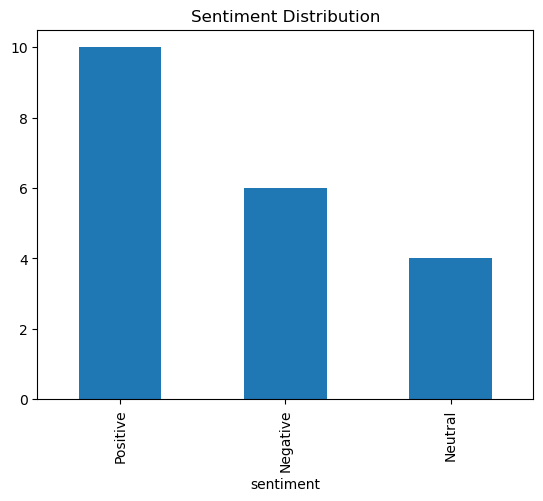

In [24]:
df['sentiment'].value_counts().plot(kind='bar', title='Sentiment Distribution')

<Axes: title={'center': 'Importance Distribution'}, xlabel='importance'>

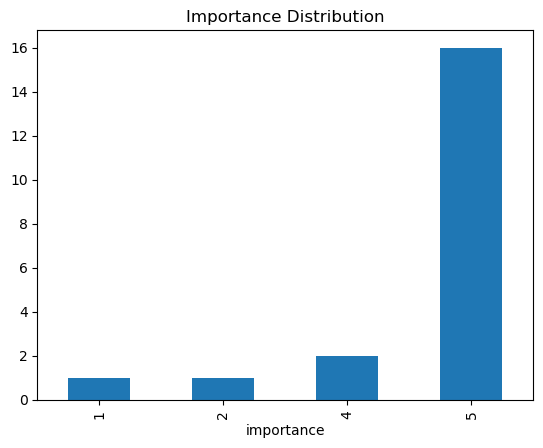

In [25]:
df['importance'].value_counts().sort_index().plot(kind='bar', title='Importance Distribution')

In [26]:
TICKER=current_stock

In [27]:
df[df['sentiment']=='']
df = df[df['sentiment'] != '']

In [28]:
def calculate_sentiment_score(df):
    sentiment_scores = {
        'Positive': 1,
        'Negative': -1,
        'Neutral': 0
    }
    
    df['sentiment_score'] = df['sentiment'].map(sentiment_scores)
    
    df['weighted_score'] = df['sentiment_score'] * df['importance'].astype(int)
    
    total_importance = df['importance'].astype(int).sum()
    
    if total_importance == 0:
        return 0
    
    sentiment_score = df['weighted_score'].sum() / total_importance
    return sentiment_score

In [29]:
print(f"Sentiment Score for {TICKER}: {calculate_sentiment_score(df).round(2)}")

Sentiment Score for news: 0.25


In [30]:
import datetime

df.drop(columns=['predicted','body_text'],inplace=True)
now = datetime.datetime.now()
date_time = now.strftime("%Y-%m-%d %H-%M-%S").strip().replace(' ', '_')
df.to_csv(f"Output/Gemini/Gemini_{TICKER}_{date_time}.csv", index=False)